In [56]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import plotly
import plotly.express as px

from sklearn import metrics 
from sklearn import model_selection
from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble #ансамбли


In [57]:
shoppers_data = pd.read_csv("data/online_shoppers_intention.csv")
shoppers_data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [58]:
shoppers_data.isna().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

Теперь закодируем категориальные признаки с помощью простого горячего кодирования, используя уже знакомую нам функцию get_dummies():


In [59]:

dummy_data = pd.get_dummies(shoppers_data)
dummy_data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1


Sessions without purchase : 84.53%
Sessions with purchase: 15.47%


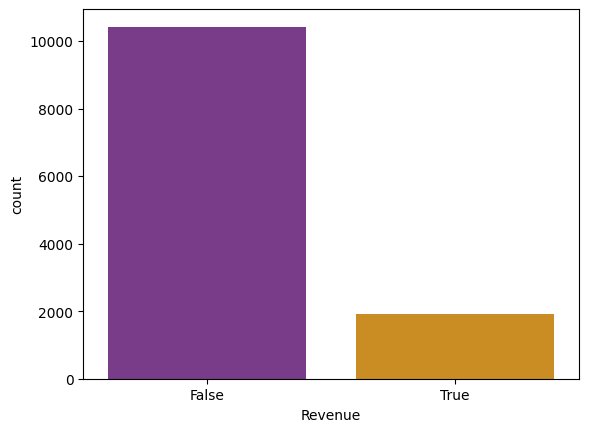

In [60]:
sns.countplot(x='Revenue', data=dummy_data, palette='CMRmap')
class_percent = dummy_data['Revenue'].value_counts(normalize=True) * 100
print('Sessions without purchase : {:.2f}%'.format(class_percent[0]))
print('Sessions with purchase: {:.2f}%'.format(class_percent[1]))

Из 12330 сессий покупкой товара завершаются лишь 15.47 %. Мы знаем, что такое соотношение классов заставляет нас смотреть на метрики для каждого из классов отдельно.

Условимся, что лучшей будет считаться та модель, у которой значение метрики  для пользователей, совершивших покупку, будет наибольшим.

По традиции разделим набор данных на матрицу наблюдений X и вектор ответов y:



In [61]:
X, y = dummy_data.drop('Revenue', axis=1), dummy_data['Revenue']


Давайте заранее определимся, как мы будем производить контроль качества наших моделей:

Разделим выборку на тренировочную и тестовую.
Будем проводить кросс-валидацию на тренировочной выборке (то есть будем делить её на тренировочные и валидационные фолды и считать среднее значение метрики по фолдам).
Итого мы будем использовать три показателя:

значение метрики на тренировочных и валидационных фолдах кросс-валидации (по ним мы будем отслеживать переобучение модели и подбирать внешние параметры);
значение метрики на отложенной тестовой выборке (оно будет нашим контрольным показателем).
Другими словами, мы будем сочетать hold-оut- и k-fold-подходы к валидации.

In [62]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y,stratify=y, test_size=0.2, random_state=42)
print(X_valid.shape[0])
print(X_train.shape[0])

2466
9864



Коллеги посоветовали нам использовать случайный лес (Random Forest) для решения данной задачи. Давайте последуем их совету.

Создайте модель случайного леса. В качестве значения параметра random_state возьмите число 42. Остальные параметры оставьте по умолчанию.

Оцените качество такой модели с помощью кросс-валидации по пяти фолдам. Так как классы несбалансированы, используйте кросс-валидатор StratifiedKFold (перемешивать выборку не нужно).

Для проведения кросс-валидации используйте функцию cross_validate(). Набор данных (параметры X, y) — тренировочная выборка (X_train, y_train). Метрика — -score.

Чему равно среднее значение метрики  на тренировочных и валидационных фолдах? Ответ округлите до двух знаков после точки-разделителя.

Средняя -score на тренировочных фолдах:

In [63]:


rf_model = ensemble.RandomForestClassifier(random_state=42)

sk = model_selection.StratifiedKFold(n_splits=5)

cv_metrics = model_selection.cross_validate(
    estimator=rf_model,
    X=X_train,
    y=y_train,
    scoring='f1',
    return_train_score=True
)

print('Train k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['train_score'])))
print('Valid k-fold mean f1: {:.2f}'.format(np.mean(cv_metrics['test_score'])))

Train k-fold mean f1: 1.00
Valid k-fold mean f1: 0.65


c:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
c:\Users\Lenovo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true n

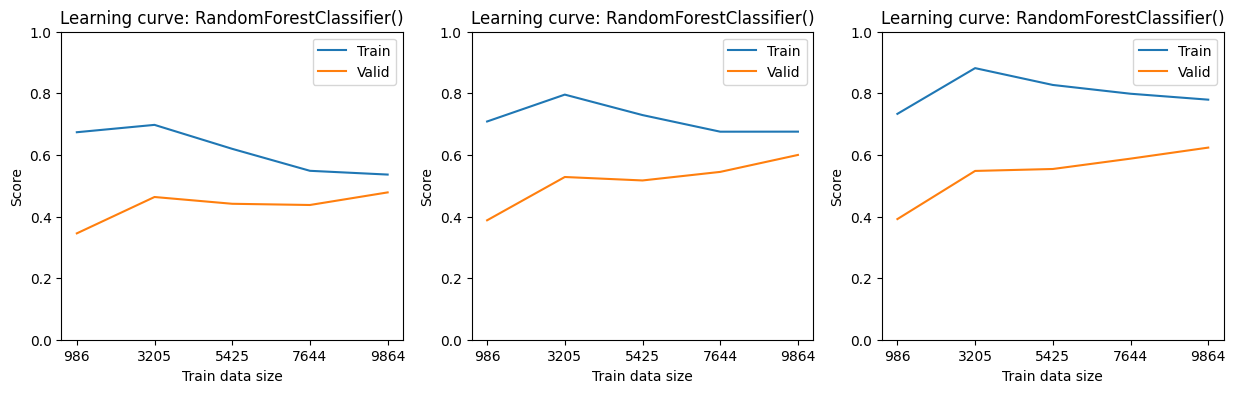

In [64]:
models = [
    ensemble.RandomForestClassifier(n_estimators=200, max_depth=5, min_samples_leaf=5,random_state=42),
    ensemble.RandomForestClassifier(n_estimators=200, max_depth=7, min_samples_leaf=5,random_state=42),
    ensemble.RandomForestClassifier(n_estimators=200, max_depth=12, min_samples_leaf=5,random_state=42)
]

def plot_learning_curve(model, X, y, cv, scoring="f1", ax=None, title=""):
    # Вычисляем координаты для построения кривой обучения
    train_sizes, train_scores, valid_scores = model_selection.learning_curve(
        estimator=model,  # модель
        X=X,  # матрица наблюдений X
        y=y,  # вектор ответов y
        cv=cv,  # кросс-валидатор
        scoring=scoring,  # метрика
    )
    # Вычисляем среднее значение по фолдам для каждого набора данных
    train_scores_mean = np.mean(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    # Если координатной плоскости не было передано, создаём новую
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 4))  # фигура + координатная плоскость
    # Строим кривую обучения по метрикам на тренировочных фолдах
    ax.plot(train_sizes, train_scores_mean, label="Train")
    # Строим кривую обучения по метрикам на валидационных фолдах
    ax.plot(train_sizes, valid_scores_mean, label="Valid")
    # Даём название графику и подписи осям
    ax.set_title("Learning curve: {}".format(title))
    ax.set_xlabel("Train data size")
    ax.set_ylabel("Score")
    # Устанавливаем отметки по оси абсцисс
    ax.xaxis.set_ticks(train_sizes)
    # Устанавливаем диапазон оси ординат
    ax.set_ylim(0, 1)
    # Отображаем легенду
    ax.legend()

skf = model_selection.StratifiedKFold(n_splits=5)

fig, axes = plt.subplots(1, 3, figsize=(15, 4)) #фигура + 3 координатных плоскости
#Создаем цикл по списку моделей и индексам этого списка

for i, model in enumerate(models): #i-текущий индекс, model - текущая модель
    plot_learning_curve(
        model, X, y, 
        skf, 
        ax=axes[i], 
        title=model.__class__.__name__ + '()'
)

In [65]:
model = ensemble.RandomForestClassifier(n_estimators=200, max_depth=7, min_samples_leaf=5,random_state=42)

model.fit(X_train,y_train)

y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_valid)

print(metrics.classification_report(y_train, y_train_predict))
print(metrics.classification_report(y_valid, y_test_predict))

              precision    recall  f1-score   support

       False       0.93      0.98      0.95      8338
        True       0.86      0.57      0.68      1526

    accuracy                           0.92      9864
   macro avg       0.89      0.78      0.82      9864
weighted avg       0.92      0.92      0.91      9864

              precision    recall  f1-score   support

       False       0.91      0.98      0.94      2084
        True       0.79      0.49      0.60       382

    accuracy                           0.90      2466
   macro avg       0.85      0.73      0.77      2466
weighted avg       0.89      0.90      0.89      2466



Best threshold = 0.36, F1-Score = 0.69


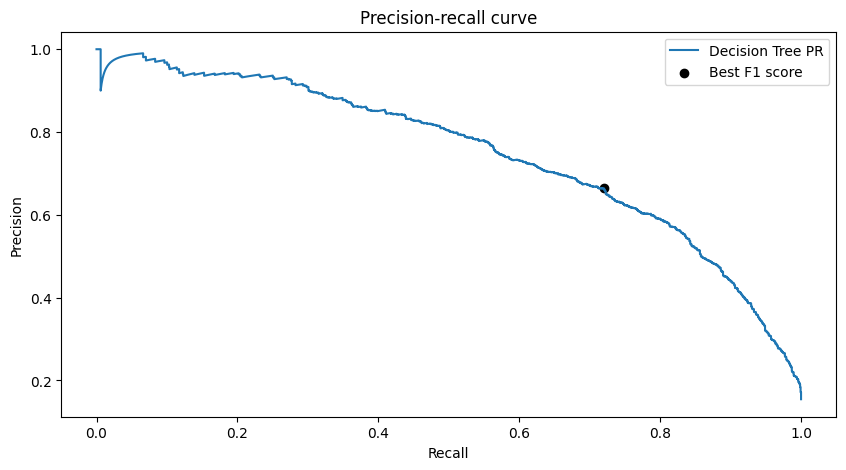

In [66]:
model = ensemble.RandomForestClassifier(n_estimators=200, max_depth=7, min_samples_leaf=5,random_state=42)

skf = model_selection.StratifiedKFold(n_splits=5)

cv_metrics_predict = model_selection.cross_val_predict(
    estimator=model,
    X=X_train,
    y=y_train,
    cv=skf,
    method='predict_proba'
)
precision, recall, thresholds = metrics.precision_recall_curve(y_train, cv_metrics_predict[:, 1])

f1_scores = (2 * precision * recall) / (precision + recall)
#Определяем индекс максимума
idx = np.argmax(f1_scores)
print('Best threshold = {:.2f}, F1-Score = {:.2f}'.format(thresholds[idx], f1_scores[idx]))

#Строим PR-кривую
fig, ax = plt.subplots(figsize=(10, 5)) #фигура + координатная плоскость
#Строим линейный график зависимости precision от recall
ax.plot(recall, precision, label='Decision Tree PR')
#Отмечаем точку максимума F1
ax.scatter(recall[idx], precision[idx], marker='o', color='black', label='Best F1 score')
#Даем графику название и подписи осям
ax.set_title('Precision-recall curve')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
#Отображаем легенду
ax.legend();